# CE-40959: Advanced Machine Learning
## HW4 - Multi-task and goal conditioned RL

#### Name: Mohammad Mozafari
#### Student No.: 400201167 

In this assignment we will be looking at goal-conditioned reinforcement learning and
hindsight experience replay (HER). In particular, you will:
1. Adapt an existing model (a Deep Q-Network) to be goal-conditioned
2. Implement Hindsight Experience Replay (HER) on top of a goal-conditioned
DQN
3. Compare the performance with and without HER


In this assignment, we will be running goal-conditioned Q-learning on two problems:
**(a)** a toy problem where we flip bits in a bit vector to match it to the current goal vector
and **(b)** move the end effector of a simulated robotic arm to the desired goal position

<font color='red'>Submission: To submit your homework, submit this notebook written answers and Tensorboard graphs screenshots to the questions
below</font>

**Environment 1:** Bit Flipping Environment
In the bit-flipping environment, the state is a binary vector with length n. The goal is to
reach a known goal vector, which is also a binary vector with length n. At each step, we can
flip a single value in the vector (changing a 0 to 1 or a 1 to 0). This environment can very
easily be solved without reinforcement learning, but we will use a DQN to understand
how adding HER can improve performance.
The bit flipping environment is an example of an environment with sparse rewards. At
each step, we receive a reward of -1 when the goal and state vector do not match and
a reward of 0 when they do. With a larger vector size, we receive fewer non-negative
rewards.


**Environment 2:** 2D Sawyer Arm
The Sawyer Arm is a multi-jointed robotic arm for grasping and reaching (https://robots.
ieee.org/robots/sawyer/). The arm operates in a 2D space, and the goal is to move the
robot to a set of coordinates. The sawyer reach is an example of a dense reward environment, where the reward is given by negative Euclidean distance between the robot arm
and the goal state.

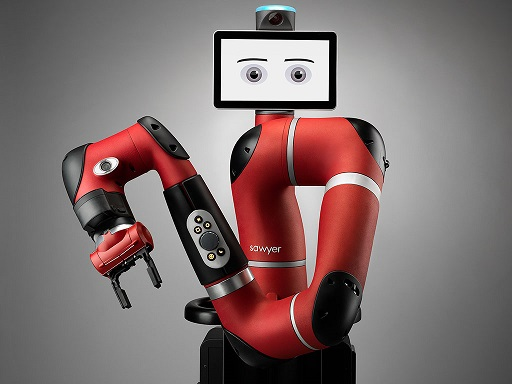

#installation

In [ ]:
!pip install imgaug==0.2.5
!pip install tensorflow-probability==0.7.0
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!pip install gym==0.15.7
!pip install free-mujoco-py

     |████████████████████████████████| 562 kB 5.2 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-py3-none-any.whl size=561438 sha256=acf089dc2aa85129686885a5ba4a73870d287a876bf51a1a9a8c20958ff14717
  Stored in directory: /root/.cache/pip/wheels/60/dd/38/d1dc2cad2b6a66dc0249261004990bccb0f27985c74ba26e49
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 981 kB 4.3 MB/s 
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.16.0
    Uninstalling tensorflow-probability-0.16.0:
      Successfully uninstalled tensorflow-probability-0.16.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-dev set to manually installed.
software-properties

In [ ]:
!git clone https://github.com/vitchyr/multiworld.git
!pip install -e ./multiworld
!pip install pygame

fatal: destination path 'multiworld' already exists and is not an empty directory.
Obtaining file:///content/multiworld
  Attempting uninstall: multiworld
    Found existing installation: multiworld 0.0.0
    Can't uninstall 'multiworld'. No files were found to uninstall.
  Running setup.py develop for multiworld


In [3]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
import os
# os.kill(os.getpid(), 9)

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/HW4

Mounted at /content/drive
/content/drive/MyDrive/HW4


In [ ]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.utils import tensorboard
import gym
import multiworld
import mujoco_py 

import bit_flip_env
import sawyer_action_discretize
from utils import HERType
import replay_buffer as experience_buffer
import q_network
import utils
from utils import HERType

pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
'''Test dependencies.'''
import sawyer_action_discretize
multiworld.register_all_envs()

if __name__ == '__main__':
    env = gym.make('SawyerReachXYEnv-v1')
    env = sawyer_action_discretize.SawyerActionDiscretize(
            env, render_every_step=False)
    env.reset()
    for _ in range(10):
        env.step(0)

    print('\n\nDependencies successfully installed!\n\n')




Dependencies successfully installed!




/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


#Implementation (10 points)

##run_episode (5 points)

In [ ]:
"""Complete the code marked TODO."""

def run_episode(
    env,
    q_net, # pylint: disable=unused-argument
    steps_per_episode,
):
    """Runs the current policy on the given environment.

    Args:
        env (gym): environment to generate the state transition
        q_net (QNetwork): Q-Network used for computing the next action
        steps_per_episode (int): number of steps to run the policy for

    Returns:
        episode_experience (list): list containing the transitions
                        (state, action, reward, next_state, goal_state)
        episodic_return (float): reward collected during the episode
        succeeded (bool): DQN succeeded to reach the goal state or not
    """

    # list for recording what happened in the episode
    episode_experience = []
    succeeded = False
    episodic_return = 0.0

    # reset the environment to get the initial state
    state, goal_state = env.reset() # pylint: disable=unused-variable

    for _ in range(steps_per_episode):

        # ======================== TODO modify code ========================

        # append goal state to input, and prepare for feeding to the q-network
        input_vector = torch.from_numpy(np.concatenate((state, goal_state))).type(torch.FloatTensor)

        # forward pass to find action
        action_scores = q_net(input_vector)

        # take action, use env.step
        action = action_scores.argmax()

        # add transition to episode_experience as a tuple of
        # (state, action, reward, next_state, goal)
        next_state, reward, done, info = env.step(action.item())
        episode_experience.append((state, action, reward, next_state, goal_state))

        # update episodic return
        episodic_return += reward

        # update state
        state = next_state

        # update succeeded bool from the info returned by env.step
        succeeded = info["successful_this_state"]

        # break the episode if done=True
        if done:
            break

        # ========================      END TODO       ========================

    return episode_experience, episodic_return, succeeded


##update_replay_buffer (5 points)

In [ ]:
"""Main training loop used for training both sawyer_main and bit flipping.

Modify the code in the sections marked TODO."""


def update_replay_buffer(
    replay_buffer,
    episode_experience,
    her_type=HERType.NO_HINDSIGHT,
    env_reward_function=None, # pylint: disable=unused-argument
    num_relabeled=4, # pylint: disable=unused-argument
):
    """Adds past experience to the replay buffer. Training is done with
    episodes from the replay buffer. When HER is used, relabeled
    experiences are also added to the replay buffer.

    Args:
        replay_buffer (ReplayBuffer): replay buffer to store experience
        episode_experience (list): list containing the transitions
            (state, action, reward, next_state, goal_state)
        HER (HERType): type of hindsight experience replay to use
        env_reward_function ((ndarray, ndarray) -> float):
            reward function for relabelling transitions
        num_relabeled (int): number of relabeled transition per transition
    """

    for timestep in range(len(episode_experience)):

        # copy experience from episode_experience to replay_buffer
        state, action, reward, next_state, goal = episode_experience[timestep]
        # use replay_buffer.add
        replay_buffer.add(np.append(state, goal),
                          action,
                          reward,
                          np.append(next_state, goal))

        # ======================== TODO modify code ========================

        if her_type == HERType.FINAL:
            # relabel episode based on final state in episode

            # get final goal
            final_goal = episode_experience[-1][3]

            # compute new reward
            reward = env_reward_function(next_state, final_goal)

            # add to buffer
            replay_buffer.add(
                    np.append(state, final_goal),
                    action,
                    reward,
                    np.append(next_state, final_goal))

        elif her_type == HERType.FUTURE:
            # future: relabel episode based on randomly sampled future state.
            # At each timestep t, relabel the goal with a randomly selected
            # timestep between t and the end of the episode

            # for every transition, add num_relabeled transitions to the buffer
            for _ in range(num_relabeled):

                # get random future goal
                random_future = np.random.randint(timestep, len(episode_experience))
                future_goal = episode_experience[random_future][3]

                # compute new reward
                reward = env_reward_function(next_state, future_goal)

                # add to replay buffer
                replay_buffer.add(
                    np.append(state, future_goal),
                    action,
                    reward,
                    np.append(next_state, future_goal))

        elif her_type == HERType.RANDOM:
            # random: relabel episode based on a random state from the episode

            # for every transition, add num_relabeled transitions to the buffer
            for _ in range(num_relabeled):

                # get random goal
                random_step = np.random.randint(0, len(episode_experience))
                random_goal = episode_experience[random_step][3]

                # compute new reward
                reward = env_reward_function(next_state, random_goal)

                # add to replay buffer
                replay_buffer.add(
                    np.append(state, random_goal),
                    action,
                    reward,
                    np.append(next_state, random_goal))

        # ========================      END TODO       ========================

def train(
    env,
    input_dim,
    action_dim,
    num_epochs,
    writer,
    her_type=HERType.NO_HINDSIGHT,
    env_reward_function=None,
    num_relabeled=4,
    buffer_size=1e6,
    num_episodes=16,
    steps_per_episode=50,
    gamma=0.98,
    opt_steps=40,
    batch_size=128,
    log_interval=5,
):
    """Main loop for training DQN on the sawyer environment. The DQN is
    trained for num_epochs. In each epoch, the agent runs in the environment
    num_episodes number of times. The Q-target and Q-policy networks are
    updated at the end of each epoch. Within one episode, Q-policy attempts
    to solve the environment and is limited to the same number as steps as the
    size of the environment.

    Args:
        env (gym object): main environment to sample transitions.
        input_dim (int): input size for the Q-network.
        action_dim (int): action space for the environment,
            output dim for Q-network.
        num_epochs (int): number of epochs to train DQN for
        her_type (HERType): Specify version of hindsight experience replay,
            defaults to None
        num_relabeled (int): number of relabelled trajectories per
            collected trajectory when using HER
        buffer_size (int): number of recent experiences to store in the
            replay buffer
        num_episodes (int): number of goals attempted per epoch
        steps_per_episode (int): number of steps_per_episode
        gamma (float): discount factor for RL
        opt_steps (int): number of gradient steps per epoch
        batch_size (int): number of transitions sampled from the
            replay buffer per optimization step
        writer (tensorboard.SummaryWriter): tensorboard event logger
        log_interval (int): frequency for recording tensorboard events
    """

    # create replay buffer
    replay_buffer = experience_buffer.Buffer(buffer_size, batch_size)

    # set up Q-policy (model) and Q-target (target_model)
    model = q_network.QNetwork(input_dim, action_dim)
    target_model = q_network.QNetwork(input_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # start by making Q-target and Q-policy the same
    utils.update_target(model, target_model)

    # Run for a fixed number of epochs
    for epoch_idx in range(num_epochs):
        # total reward for the epoch
        total_reward = 0.0
        # record success rate for each episode of the epoch
        successes = []
        # loss at the end of each epoch
        losses = []

        for _ in range(num_episodes):
            # collect data in the environment
            episode_experience, ep_reward, succeeded = run_episode(
                env, model, steps_per_episode)
            # track eval metrics in the environment
            total_reward += ep_reward
            successes.append(succeeded)
            # add to the replay buffer; use specified HER policy
            update_replay_buffer(
                replay_buffer,
                episode_experience,
                her_type=her_type,
                env_reward_function=env_reward_function,
                num_relabeled=num_relabeled
            )

        # optimize the Q-policy network
        for _ in range(opt_steps):
            # sample from the replay buffer
            state, action, reward, next_state = replay_buffer.sample()
            state = torch.from_numpy(state.astype(np.float32))
            action = torch.from_numpy(action)
            reward = torch.from_numpy(reward.astype(np.float32))
            next_state = torch.from_numpy(next_state.astype(np.float32))

            optimizer.zero_grad()
            # forward pass through target network
            target_q_vals = target_model(next_state).detach()
            # calculate target reward
            q_loss_target = torch.clip(
                reward + gamma * torch.max(target_q_vals, axis=-1).values,
                -1.0 / (1 - gamma),
                0)
            # calculate predictions and loss
            model_predict = model(state)
            model_action_taken = torch.reshape(action, [-1])
            action_one_hot = nn.functional.one_hot(
                model_action_taken, action_dim)
            q_val = torch.sum(model_predict * action_one_hot, axis=1)
            criterion = nn.MSELoss()
            loss = criterion(q_val, q_loss_target)
            losses.append(loss.detach().numpy())

            loss.backward()
            optimizer.step()

        # update target model by copying Q-policy to Q-target
        utils.update_target(model, target_model)

        if epoch_idx % log_interval == 0:
            print(
                f"Epoch: {epoch_idx} Cumulative reward: {total_reward} Success rate: {np.mean(successes)} Mean loss: {np.mean(losses)}" # pylint: disable=line-too-long
            )
            writer.add_scalar(
                "eval_metrics/total_reward", total_reward, epoch_idx)
            writer.add_scalar(
                "eval_metrics/success_rate", np.mean(successes), epoch_idx)
            writer.add_scalar(
                "train_metrics/td_loss", np.mean(losses), epoch_idx)


In [ ]:
def main(log_dir=None, env='bit_flip', num_bits=7, num_epochs=250, her_type='no_hindsight', random_seed=42):
    multiworld.register_all_envs()

    torch.manual_seed(random_seed)

    if env == 'bit_flip':
        env = bit_flip_env.BitFlipEnv(num_bits)
        input_dim = 2 * num_bits
        action_dim = num_bits
        steps_per_episode = num_bits
        env_reward_function = lambda x, y: 0.0 if np.array_equal(x, y) else -1.0
        tensorboard_log_dir = (
            f'./logs/gcrl/bit_flip/num_bits:{num_bits}/HER_type:{her_type}/seed:{random_seed}' # pylint: disable=line-too-long
        ) if log_dir is None else log_dir

    elif env == 'sawyer_reach':
        env = gym.make('SawyerReachXYEnv-v1')
        env = sawyer_action_discretize.SawyerActionDiscretize(
            env, render_every_step=False)
        input_dim = 4
        action_dim = 4
        steps_per_episode = 50
        env_reward_function = lambda x, y: -np.linalg.norm(x - y)
        tensorboard_log_dir = (
            f'./logs/gcrl/sawyer_reach/HER_type:{her_type}/seed:{random_seed}' # pylint: disable=line-too-long
        ) if log_dir is None else log_dir

    print(f'logging experiment at: {tensorboard_log_dir}')
    writer = tensorboard.SummaryWriter(log_dir=tensorboard_log_dir)
    train(
        env=env,
        input_dim=input_dim,
        action_dim=action_dim,
        env_reward_function=env_reward_function,
        num_epochs=num_epochs,
        steps_per_episode=steps_per_episode,
        her_type=HERType[her_type.upper()],
        writer=writer,
    )

# Problem 1: Implementing Goal-conditioned RL (5 points)

We have a goal-conditioned DQN. The Q-function takes in the concatenated state and
goal as input. You can think of the goal-conditioned implementation as an extended
Markov decision process (MDP), where your state space contains both the original state
and the goal

In [ ]:
main(env='bit_flip', num_bits=6, num_epochs=250, her_type='no_hindsight')

logging experiment at: ./logs/gcrl/bit_flip/num_bits:6/HER_type:no_hindsight/seed:42
Epoch: 0 Cumulative reward: -91.0 Success rate: 0.0625 Mean loss: 0.17008979618549347
Epoch: 5 Cumulative reward: -96.0 Success rate: 0.0 Mean loss: 0.12116066366434097
Epoch: 10 Cumulative reward: -96.0 Success rate: 0.0 Mean loss: 0.10342516005039215
Epoch: 15 Cumulative reward: -89.0 Success rate: 0.125 Mean loss: 0.09732550382614136
Epoch: 20 Cumulative reward: -83.0 Success rate: 0.1875 Mean loss: 0.0808609277009964
Epoch: 25 Cumulative reward: -79.0 Success rate: 0.25 Mean loss: 0.08224420249462128
Epoch: 30 Cumulative reward: -92.0 Success rate: 0.0625 Mean loss: 0.06763643026351929
Epoch: 35 Cumulative reward: -79.0 Success rate: 0.1875 Mean loss: 0.06589847058057785
Epoch: 40 Cumulative reward: -75.0 Success rate: 0.3125 Mean loss: 0.05763951689004898
Epoch: 45 Cumulative reward: -93.0 Success rate: 0.0625 Mean loss: 0.05658518150448799
Epoch: 50 Cumulative reward: -81.0 Success rate: 0.1875 M

<font color='red'>Verify the eval metrics, that is total reward should be above -40.0 and success rate
should be 1.0. </font>

#Problem 2: Adding HER to Bit Flipping (8 points)

With HER, the model is trained on the actual (state, goal, reward) tuples along with (state,
goal, reward) tuples where the goal has been relabeled. The goals are relabeled to be what
state was actually reached and the rewards correspondingly relabeled. In other words, we
pretend that the state we reached was always our goal. HER gives us more examples of
actions that lead to positive rewards. The reward function for relabeled goals is the same
as the environment reward function; for the bit flipping environment, the reward is -1 if
the state and goal vector do not match and 0 if they do match.

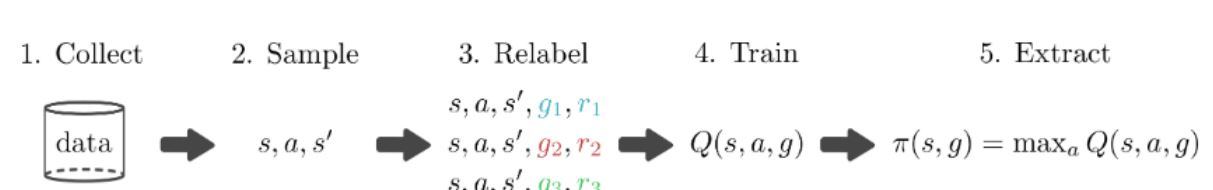

There are three different variations of HER: final, random, and future. In each variation,
the goal is relabeled differently:

• final: The final state of the episode is used as the goal

• random: A random state in the episode is used as the goal

• future: A random future state of the episode is used as the goal


In [ ]:
main(env='bit_flip', num_bits=6, num_epochs=250, her_type='no_hindsight')
main(env='bit_flip', num_bits=15, num_epochs=500, her_type='no_hindsight')

logging experiment at: ./logs/gcrl/bit_flip/num_bits:6/HER_type:no_hindsight/seed:42
Epoch: 0 Cumulative reward: -96.0 Success rate: 0.0 Mean loss: 0.17004425823688507
Epoch: 5 Cumulative reward: -86.0 Success rate: 0.125 Mean loss: 0.11826213449239731
Epoch: 10 Cumulative reward: -92.0 Success rate: 0.0625 Mean loss: 0.10224635899066925
Epoch: 15 Cumulative reward: -90.0 Success rate: 0.0625 Mean loss: 0.09303108602762222
Epoch: 20 Cumulative reward: -84.0 Success rate: 0.1875 Mean loss: 0.08699723333120346
Epoch: 25 Cumulative reward: -93.0 Success rate: 0.0625 Mean loss: 0.07909057289361954
Epoch: 30 Cumulative reward: -96.0 Success rate: 0.0 Mean loss: 0.06948453187942505
Epoch: 35 Cumulative reward: -90.0 Success rate: 0.0625 Mean loss: 0.064939484000206
Epoch: 40 Cumulative reward: -86.0 Success rate: 0.1875 Mean loss: 0.058235425502061844
Epoch: 45 Cumulative reward: -77.0 Success rate: 0.3125 Mean loss: 0.0504947192966938
Epoch: 50 Cumulative reward: -86.0 Success rate: 0.125 M

In [ ]:
main(env='bit_flip', num_bits=6, num_epochs=250, her_type='final')
main(env='bit_flip', num_bits=15, num_epochs=500, her_type='final')

logging experiment at: ./logs/gcrl/bit_flip/num_bits:6/HER_type:final/seed:42
Epoch: 0 Cumulative reward: -96.0 Success rate: 0.0 Mean loss: 0.21564403176307678
Epoch: 5 Cumulative reward: -92.0 Success rate: 0.0625 Mean loss: 0.18474538624286652
Epoch: 10 Cumulative reward: -74.0 Success rate: 0.3125 Mean loss: 0.15137065947055817
Epoch: 15 Cumulative reward: -59.0 Success rate: 0.5625 Mean loss: 0.12540799379348755
Epoch: 20 Cumulative reward: -35.0 Success rate: 0.9375 Mean loss: 0.07359857857227325
Epoch: 25 Cumulative reward: -38.0 Success rate: 1.0 Mean loss: 0.043585628271102905
Epoch: 30 Cumulative reward: -28.0 Success rate: 1.0 Mean loss: 0.03253677487373352
Epoch: 35 Cumulative reward: -29.0 Success rate: 1.0 Mean loss: 0.02564052678644657
Epoch: 40 Cumulative reward: -34.0 Success rate: 1.0 Mean loss: 0.01877017877995968
Epoch: 45 Cumulative reward: -35.0 Success rate: 1.0 Mean loss: 0.017389964312314987
Epoch: 50 Cumulative reward: -25.0 Success rate: 1.0 Mean loss: 0.0153

In [ ]:
main(env='bit_flip', num_bits=6, num_epochs=250, her_type='random')
main(env='bit_flip', num_bits=15, num_epochs=500, her_type='random')

logging experiment at: ./logs/gcrl/bit_flip/num_bits:6/HER_type:random/seed:42
Epoch: 0 Cumulative reward: -84.0 Success rate: 0.125 Mean loss: 0.18861278891563416
Epoch: 5 Cumulative reward: -82.0 Success rate: 0.1875 Mean loss: 0.1785159558057785
Epoch: 10 Cumulative reward: -61.0 Success rate: 0.5 Mean loss: 0.08971087634563446
Epoch: 15 Cumulative reward: -50.0 Success rate: 0.6875 Mean loss: 0.06548226624727249
Epoch: 20 Cumulative reward: -52.0 Success rate: 0.625 Mean loss: 0.06131066009402275
Epoch: 25 Cumulative reward: -33.0 Success rate: 1.0 Mean loss: 0.04048530384898186
Epoch: 30 Cumulative reward: -32.0 Success rate: 1.0 Mean loss: 0.029450014233589172
Epoch: 35 Cumulative reward: -35.0 Success rate: 1.0 Mean loss: 0.021644936874508858
Epoch: 40 Cumulative reward: -29.0 Success rate: 1.0 Mean loss: 0.018909625709056854
Epoch: 45 Cumulative reward: -31.0 Success rate: 1.0 Mean loss: 0.016529042273759842
Epoch: 50 Cumulative reward: -33.0 Success rate: 1.0 Mean loss: 0.0154

<font color='red'>For the above, explain your findings and why you expect the methods to perform in
the observed manner for varying numbers of bits and varying relabeling strategies.
Keep your write-up concise and summarize your observations across all parts.</font> 

<p>6-bits case is easy so, even the no-hindsight can solve it but increasing the number of bits makes the problem more difficult because then the probability of reaching the goal state decreases. Because of this, when we are not using HER, the system always gets -1 reward (because it's very unlikely to randomly reach the goal state) and consequently won't have any measure of preference over actions. This makes it impossible for the system to learn anything. That's why we see the (15-bits, no-hindsight) case fail.</p>
<p>In order to alleviate this problem, HER uses a technique to simulate cases where we do get 0 reward (different from -1). Because of this the system can now differentiate action quality. This is why we see success for both cases that use HER for both 6 and 15 bits. Obviously 15 bits would be more difficult and that's why it takes longer to converge.</p>
<p>The convergence speed for both "random HER" and "final HER" is almost the same. This is mainly because 6-bits and 15-bits are probably too easy for them. If we test with longer sequences we'd probably see that "random-HER" is faster. This can be due to the fact that "final HER" uses the same goal for all tuples in an episode while "random HER" uses different goal states. Because of this we'd have more diverse data to train the Q function. This can force the system to learn better Q functions which amounts to better policies.</p>

#Problem 3: Analyzing HER for Sawyer Reach (7 points)


If implemented correctly, HER should work for the second environment, Sawyer Reach.
Compare the performance of the Sawyer arm with and without HER. Run the following
commands:

In [ ]:
main(env='sawyer_reach', num_epochs=1000, her_type='no_hindsight')

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


logging experiment at: ./logs/gcrl/sawyer_reach/HER_type:no_hindsight/seed:42
Epoch: 0 Cumulative reward: -148.67571585423448 Success rate: 0.0 Mean loss: 0.008332553319633007
Epoch: 5 Cumulative reward: -84.59089453513279 Success rate: 0.0625 Mean loss: 0.0021237912587821484
Epoch: 10 Cumulative reward: -83.2999994440674 Success rate: 0.0625 Mean loss: 0.0021242406219244003
Epoch: 15 Cumulative reward: -71.95234504777804 Success rate: 0.0625 Mean loss: 0.002040094928815961
Epoch: 20 Cumulative reward: -85.11709085752544 Success rate: 0.0625 Mean loss: 0.002303277375176549
Epoch: 25 Cumulative reward: -89.91676582854019 Success rate: 0.0625 Mean loss: 0.002275855978950858
Epoch: 30 Cumulative reward: -76.53218781165246 Success rate: 0.125 Mean loss: 0.00238185771740973
Epoch: 35 Cumulative reward: -55.612096748257535 Success rate: 0.125 Mean loss: 0.002580361207947135
Epoch: 40 Cumulative reward: -65.77256467305354 Success rate: 0.125 Mean loss: 0.0029643140733242035
Epoch: 45 Cumulati

In [ ]:
main(env='sawyer_reach', num_epochs=1000, her_type='final')

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


logging experiment at: ./logs/gcrl/sawyer_reach/HER_type:final/seed:42
Epoch: 0 Cumulative reward: -144.0755799658945 Success rate: 0.0 Mean loss: 0.007078046444803476
Epoch: 5 Cumulative reward: -92.09578027652543 Success rate: 0.0 Mean loss: 0.002897572936490178
Epoch: 10 Cumulative reward: -76.93800678702449 Success rate: 0.125 Mean loss: 0.003170039039105177
Epoch: 15 Cumulative reward: -83.57949977932392 Success rate: 0.0625 Mean loss: 0.0028384660836309195
Epoch: 20 Cumulative reward: -68.33833264991463 Success rate: 0.0625 Mean loss: 0.00348317320458591
Epoch: 25 Cumulative reward: -71.1736248434337 Success rate: 0.0625 Mean loss: 0.0037464580964297056
Epoch: 30 Cumulative reward: -75.14018197174522 Success rate: 0.0 Mean loss: 0.004577035550028086
Epoch: 35 Cumulative reward: -77.37319239143571 Success rate: 0.125 Mean loss: 0.005033655092120171
Epoch: 40 Cumulative reward: -87.48396193955875 Success rate: 0.0625 Mean loss: 0.0060640545561909676
Epoch: 45 Cumulative reward: -86


<font color='red'>
a) Submit the tensorboard screenshot comparing the eval metrics in your report.</font>


<font color='red'>
b) Discuss your findings: Compare the role of HER in
Sawyer Reach.
</font>

<p> The following plots show how success_rate and total_reward changes during training for both cases. <br /> Green: not using HER <br /> Gray: Using HER </p>

<p> It can be seen that when not using relabeling, the agent fails to learn the optimal policy, while with HER the agent can reach 100% success rate. This is due to the fact that this game is a long-horizon environment and because of this relying upon chance to reach the goal state is pointless. As a result the agent usually gets the same negative reward and can't find the good actions. With HER we create subgoals which allow the agent to differentiate between different actions and thus is able to improve its policy. </p> 

<div>
<img src="https://drive.google.com/uc?export=view&id=11_qc10BdS98oRgBWw5yM15PWR0uQq2aL" width="800"/>
</div>

<div>
<img src="https://drive.google.com/uc?export=view&id=1GyArDTLrrkFPGeOSBwzh58Di5_Pz7wcs" width="800"/>
</div>